In [1]:
import pandas as pd
import numpy as np
from glob import glob

# Load CSVs
files = glob('scan_data/*.csv')
df_list = []
for file in files:
    df = pd.read_csv(file, skiprows=5, na_values=['', 'NaN', -99.9])
    df = df.loc[:, ~df.columns.str.contains('^Unnamed', na=False)]
    df.columns = [' '.join(col.split()) for col in df.columns.str.strip()]
    df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%Y-%m-%d %H:%M', errors='coerce')
    df = df.dropna(subset=['datetime'])
    df = df.set_index('datetime').drop(['Date', 'Time'], axis=1, errors='ignore')
    df_list.append(df)

# Concatenate and sort
df = pd.concat(df_list).sort_index()

# Normalize column names
df.columns = [' '.join(col.split()) for col in df.columns.str.strip()]

# Replace -99.9 with NaN
df = df.replace(-99.9, np.nan)

# Check NaN proportions
nan_proportions = df.isna().mean()
print("NaN proportions:\n", nan_proportions)

# Drop columns with >30% NaNs
valid_cols = nan_proportions[nan_proportions < 0.3].index
df = df[valid_cols]
print("Kept columns:", valid_cols)

# Use PRCP.H-1 (in) as primary precipitation
if 'PRCP.H-1 (in)' in df.columns:
    df['Precip (in)'] = df['PRCP.H-1 (in)'].fillna(0)
    df = df.drop('PRCP.H-1 (in)', axis=1, errors='ignore')
elif 'PREC.I-1 (in)' in df.columns:
    df['Precip (in)'] = df['PREC.I-1 (in)'].fillna(0)
    df = df.drop('PREC.I-1 (in)', axis=1, errors='ignore')
else:
    print("Warning: No precipitation column found. Adding zero-filled column.")
    df['Precip (in)'] = 0

# Subset to start at 1997-03-16
target_col = 'SMS.I-1:-4 (pct) (loam)'
if target_col not in df.columns:
    possible_targets = [col for col in df.columns if 'SMS.I-1:-8' in col]
    if possible_targets:
        target_col = possible_targets[0]
        print(f"Adjusted target_col to: {target_col}")
    else:
        raise KeyError("No SMS.I-1:-8 column found in DataFrame.")

first_valid = df[target_col].first_valid_index()
print("First non-NaN SMS.I-1:-8:", first_valid)
df = df.loc[first_valid:]  # ~245k rows

# Interpolate remaining NaNs
df = df.interpolate(method='time', limit_direction='both')

# Ensure hourly continuity
df = df.resample('h').interpolate(method='time')

# Save
df.to_csv('processed_hourly_scan_1997_2025.csv')
#print("First 5 rows:\n", df.head())
print("Columns:", df.columns)

NaN proportions:
 Site Id                     0.000000
PREC.I-1 (in)               0.854160
TOBS.I-1 (degC)             0.000612
STO.I-1:-2 (degC)           0.007993
STO.I-1:-4 (degC)           0.108889
STO.I-1:-8 (degC)           0.003780
STO.I-1:-20 (degC)          0.004372
STO.I-1:-40 (degC)          0.148136
STO.I-1:-80 (degC)          0.999796
BATT.I-1 (volt)             0.000387
STV.H-1:-4 (degC)           0.999918
SRAD.I-1 (watt)             0.993936
ETIL.I-1 (volt)             0.776799
ETIB.I-1 (volt)             0.776811
TMAX.H-1 (degC)             0.009738
TMIN.H-1 (degC)             0.009906
TAVG.H-1 (degC)             0.009865
SMS.I-1:-2 (pct) (loam)     0.028979
SMS.I-1:-4 (pct) (loam)     0.063263
SMS.I-1:-8 (pct) (loam)     0.030904
SMS.I-1:-20 (pct) (loam)    0.112363
SMS.I-1:-40 (pct) (loam)    0.202664
SAL.I-1:-2 (gram)           0.017034
SAL.I-1:-4 (gram)           0.030916
SAL.I-1:-8 (gram)           0.012821
SAL.I-1:-20 (gram)          0.016161
SAL.I-1:-40 (gram)  

In [2]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import joblib

# User-defined split date
split_date = pd.Timestamp('2020-01-01')

# Define sequence length (168 hours = 7 days)
seq_length = 168

# Load raw df (assuming this is where df is initially loaded)
# df = pd.read_csv('your_raw_data.csv', index_col='datetime', parse_dates=True)  # Example

# Add cyclic date features
df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)
df['dayofyear_sin'] = np.sin(2 * np.pi * df.index.dayofyear / 365.25)
df['dayofyear_cos'] = np.cos(2 * np.pi * df.index.dayofyear / 365.25)
df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)

# Key features (including target for autoregression)
target_col = 'SMS.I-1:-4 (pct) (loam)'
key_features = [
    'Precip (in)',
    'TOBS.I-1 (degC)',
    'TAVG.H-1 (degC)',
    'RHUM.I-1 (pct)',
    'SMS.I-1:-2 (pct) (loam)',
    target_col,
    'month_sin',
    'month_cos',
    'dayofyear_sin',
    'dayofyear_cos',
    'hour_sin',
    'hour_cos',
]
feature_cols = [col for col in df.columns if col in key_features]

# Rolling features
df['Precip_24h_sum'] = df['Precip (in)'].rolling(24).sum().fillna(0)
df['TOBS_6h_mean'] = df['TOBS.I-1 (degC)'].rolling(6).mean().fillna(0)
feature_cols += ['Precip_24h_sum', 'TOBS_6h_mean']

# Normalize features
scaler = MinMaxScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

# Save the modified df
df.to_pickle('processed_df.pkl')
print("Modified DataFrame saved as 'processed_df.pkl'")

# Split into train and test
train_df = df[df.index < split_date]
test_df = df[df.index >= split_date]

# Function to create sequences with progress tracking
def create_sequences(data, seq_length, target_col):
    xs, ys = [], []
    total_iterations = len(data) - seq_length
    for i in tqdm(range(len(data) - seq_length), total=total_iterations, desc="Creating sequences"):
        x = data[feature_cols].iloc[i:i + seq_length].values
        y = data[target_col].iloc[i + seq_length:i + seq_length + 168].values
        if len(y) == 168:
            xs.append(x)
            ys.append(y)
    return np.array(xs), np.array(ys)

# Create train/test sequences
print("Creating train sequences...")
X_train, y_train = create_sequences(train_df, seq_length, target_col)
print("Creating test sequences...")
X_test, y_test = create_sequences(test_df, seq_length, target_col)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

# (Rest of the training code, including model definition, training, and saving model/scaler)
# Save scaler
joblib.dump(scaler, 'scaler.pkl')
# Save model (already included in training loop)

Modified DataFrame saved as 'processed_df.pkl'
Creating train sequences...


Creating sequences: 100%|█████████████████████████████████████████████████████| 199646/199646 [29:06<00:00, 114.33it/s]


Creating test sequences...


Creating sequences: 100%|███████████████████████████████████████████████████████| 49924/49924 [01:41<00:00, 493.11it/s]


['scaler.pkl']

In [3]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Last time step to predict output sequence
        return out

# Hyperparameters
input_size = len(feature_cols)  # ~12
hidden_size = 64
num_layers = 2
output_size = 168  # Predict 168 hours
epochs = 20  # Reduced for initial test
batch_size = 128  # Increased to speed up
learning_rate = 0.001

# DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model, loss, optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with early stopping and model saving
best_loss = np.inf
patience = 5
counter = 0
for epoch in tqdm(range(epochs), desc="Training"):
    model.train()
    train_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    
    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            output = model(batch_x)
            val_loss += criterion(output, batch_y).item()
    val_loss /= len(test_loader)
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    # Save the best model
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'lstm_model.pth')  # Save model parameters
        print(f"Model saved with validation loss: {val_loss:.4f}")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

print(f"Training completed. Best model saved as 'lstm_model.pth' with loss: {best_loss:.4f}")

Using device: cuda


Training:   5%|███▋                                                                     | 1/20 [00:12<04:06, 12.97s/it]

Epoch 1/20, Train Loss: 0.0051, Val Loss: 0.0076
Model saved with validation loss: 0.0076


Training:  10%|███████▎                                                                 | 2/20 [00:25<03:47, 12.63s/it]

Epoch 2/20, Train Loss: 0.0036, Val Loss: 0.0073
Model saved with validation loss: 0.0073


Training:  15%|██████████▉                                                              | 3/20 [00:37<03:32, 12.52s/it]

Epoch 3/20, Train Loss: 0.0035, Val Loss: 0.0078


Training:  20%|██████████████▌                                                          | 4/20 [00:50<03:19, 12.45s/it]

Epoch 4/20, Train Loss: 0.0034, Val Loss: 0.0096


Training:  25%|██████████████████▎                                                      | 5/20 [01:02<03:06, 12.41s/it]

Epoch 5/20, Train Loss: 0.0033, Val Loss: 0.0062
Model saved with validation loss: 0.0062


Training:  30%|█████████████████████▉                                                   | 6/20 [01:14<02:53, 12.40s/it]

Epoch 6/20, Train Loss: 0.0033, Val Loss: 0.0090


Training:  35%|█████████████████████████▌                                               | 7/20 [01:27<02:41, 12.39s/it]

Epoch 7/20, Train Loss: 0.0032, Val Loss: 0.0069


Training:  40%|█████████████████████████████▏                                           | 8/20 [01:39<02:28, 12.39s/it]

Epoch 8/20, Train Loss: 0.0031, Val Loss: 0.0063


Training:  45%|████████████████████████████████▊                                        | 9/20 [01:51<02:16, 12.39s/it]

Epoch 9/20, Train Loss: 0.0031, Val Loss: 0.0076


Training:  45%|████████████████████████████████▊                                        | 9/20 [02:04<02:32, 13.83s/it]

Epoch 10/20, Train Loss: 0.0030, Val Loss: 0.0077
Early stopping
Training completed. Best model saved as 'lstm_model.pth' with loss: 0.0062


In [26]:
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

def plot_prediction_at_time(input_time, df, model, target_col, scaler):
    """
    Generate a prediction graph for a user-specified time using the trained RNN model.
    
    Parameters:
    - input_time: pd.Timestamp or str (e.g., '2020-01-01 12:00') for the prediction start time
    - df: DataFrame containing the time series data
    - model: Trained LSTM model
    - target_col: Target column name (e.g., 'SMS.I-1:-4 (pct) (loam)')
    - scaler: The MinMaxScaler used for normalization (to inverse transform predictions)
    """
    # Default internal variables (adjust based on your training setup)
    target_col = 'SMS.I-1:-4 (pct) (loam)'  # From feature engineering
    feature_cols = [  # From feature engineering
        'Precip (in)',
        'TOBS.I-1 (degC)',
        'TAVG.H-1 (degC)',
        'RHUM.I-1 (pct)',
        'SMS.I-1:-2 (pct) (loam)',
        target_col,
        'month_sin',
        'month_cos',
        'dayofyear_sin',
        'dayofyear_cos',
        'hour_sin',
        'hour_cos',
        'Precip_24h_sum',
        'TOBS_6h_mean'
    ]

    # Convert input_time to Timestamp if it's a string
    if isinstance(input_time, str):
        input_time = pd.Timestamp(input_time)
    
    # Find the closest timestamp in df
    closest_time = df.index[df.index.get_indexer([input_time], method='nearest')[0]]
    print(f"Closest available time to {input_time}: {closest_time}")
    
    # Prepare input sequence (last 168 hours before closest_time)
    seq_length = 168
    seq_start = closest_time - pd.Timedelta(hours=seq_length - 1)  # 168 hours back
    input_seq = df[feature_cols].loc[seq_start:closest_time]
    if len(input_seq) < seq_length:
        print(f"Warning: Insufficient data before {closest_time}. Padding with last available data.")
        input_seq = pd.concat([df[feature_cols].iloc[-seq_length:], input_seq]).tail(seq_length)
    input_X = torch.tensor(input_seq.values).float().unsqueeze(0).to(next(model.parameters()).device)  # Move to model's device
    
    # Predict for the next 7 days (168 hours)
    model.eval()
    with torch.no_grad():
        preds = model(input_X).squeeze().cpu().numpy()  # Move to CPU before converting to NumPy
    
    # Inverse transform predictions using the target column's scaling
    target_idx = feature_cols.index(target_col)  # Get index of target_col (should be 5)
    preds_transformed = (preds * scaler.scale_[target_idx]) + scaler.min_[target_idx]  # Manual inverse transform
    
    # Interpolate to hourly (optional, since preds are already hourly)
    pred_hours = np.arange(1, 169, 1)  # 1 to 168 hours
    
    # Get historical data (past 7 days before closest_time)
    past_hours = 168
    historical_df = df[[target_col, 'Precip (in)', 'TOBS.I-1 (degC)']].loc[
        closest_time - pd.Timedelta(hours=past_hours):closest_time - pd.Timedelta(hours=1)
    ]
    historical_hours = np.arange(-past_hours, 0, 1)  # -168 to -1
    
    # Get actual data from closest_time onward (up to available data)
    actual_df = df[[target_col]].loc[closest_time:]
    if not actual_df.empty:
        time_diffs = (actual_df.index - closest_time).total_seconds() / 3600  # Convert seconds to hours
        actual_hours = time_diffs.values
    else:
        actual_hours = np.array([])
        print("Warning: No actual data available for plotting.")
    
    # Create dual-axis plot
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Left y-axis: Soil moisture (historical, predicted, actual)
    ax1.plot(historical_hours, historical_df[target_col], label='Historical SMS (-4cm)', color='blue')
    if not actual_df.empty:
        ax1.plot(actual_hours, actual_df[target_col], label='Actual SMS (-4cm)', color='green')
        print(f"Actual SMS range: {actual_hours[0]} to {actual_hours[-1]} hours")
    ax1.plot(pred_hours, preds_transformed, label='Predicted SMS (-4cm)', color='blue', linestyle='--')
    ax1.scatter(pred_hours, preds_transformed, color='red', label='Model Outputs')
    ax1.set_xlabel(f'Hours Relative to {closest_time} (0 = Prediction Start)')
    ax1.set_ylabel('Soil Moisture (%)', color='blue')
    ax1.set_xlim(-past_hours, 168)  # Limit x-axis to -168 to +168 hours
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend(loc='upper left')
    
    # Right y-axis: Precipitation and Temperature (historical)
    ax2 = ax1.twinx()
    ax2.plot(historical_hours, historical_df['Precip (in)'], label='Historical Precip (in)', color='yellow')
    ax2.plot(historical_hours, historical_df['TOBS.I-1 (degC)'], label='Historical Temp (°C)', color='orange')
    ax2.set_ylabel('Precip (in) / Temp (°C)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.legend(loc='upper right')
    
    # Title and grid
    plt.title(f'Soil Moisture Prediction from {closest_time} at 4cm')
    fig.tight_layout()
    plt.grid(True)
    plt.show()


Using device: cuda
Loaded processed DataFrame from 'processed_df.pkl'
Model and scaler loaded successfully.
Closest available time to 2025-07-12 06:00:00: 2025-07-12 06:00:00
Actual SMS range: 0.0 to 1629.0 hours


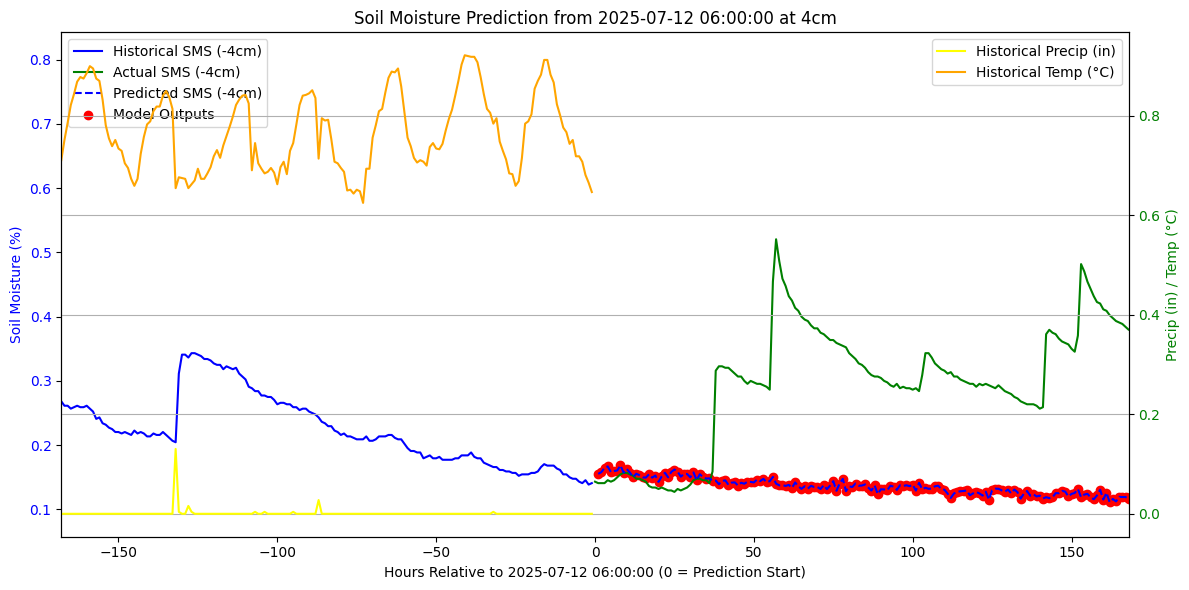

In [37]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import joblib

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the LSTMModel class
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Load the processed df
df = pd.read_pickle('processed_df.pkl')
print("Loaded processed DataFrame from 'processed_df.pkl'")

# Hyperparameters (must match training)
input_size = len([col for col in df.columns if col in [
    'Precip (in)', 'TOBS.I-1 (degC)', 'TAVG.H-1 (degC)', 'RHUM.I-1 (pct)',
    'SMS.I-1:-2 (pct) (loam)', 'SMS.I-1:-4 (pct) (loam)', 'month_sin',
    'month_cos', 'dayofyear_sin', 'dayofyear_cos', 'hour_sin', 'hour_cos',
    'Precip_24h_sum', 'TOBS_6h_mean'
]])  # Dynamically determine input_size
hidden_size = 64
num_layers = 2
output_size = 168

# Load the model
loaded_model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
loaded_model.load_state_dict(torch.load('lstm_model.pth'))
loaded_model.eval()

# Load the scaler
loaded_scaler = joblib.load('scaler.pkl')

print("Model and scaler loaded successfully.")


# Define feature_cols and target_col (consistent with training)
feature_cols = [col for col in df.columns if col in [
    'Precip (in)', 'TOBS.I-1 (degC)', 'TAVG.H-1 (degC)', 'RHUM.I-1 (pct)',
    'SMS.I-1:-2 (pct) (loam)', 'SMS.I-1:-4 (pct) (loam)', 'month_sin',
    'month_cos', 'dayofyear_sin', 'dayofyear_cos', 'hour_sin', 'hour_cos',
    'Precip_24h_sum', 'TOBS_6h_mean'
]]
target_col = 'SMS.I-1:-4 (pct) (loam)'

# Example usage with plot_prediction_at_time
plot_prediction_at_time('2025-07-12 06:00', df, loaded_model, target_col, scaler)